## Climate Classification Map

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj, transform    # In case of re-projection
from tools import cbarpam, GDFPlotOrder
import seaborn as sns
from scipy import stats
import HydroErr as he
from tools import save_hdf
from itertools import compress
from functools import reduce
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

# Load Dam Inflow data from SUTD
dfFlowDams = pd.read_hdf('./data/dfFlowDams.hdf')
ind_dams = np.load('./data/ind_dams.npz')['ind_dams']
# Load Degree of Regulation (DOR)
dor = pd.read_hdf('./data/new_dor.hdf')      # The order is sorted during the process
dam_dor = dor.loc[dor.DOR2 <= 0, 'GRAND_ID']
# Select only headwater dams (735)
idx_dor = np.isin(ind_dams[0,:], dam_dor)
damList = ind_dams[0,idx_dor]
ind_dams = ind_dams[1,idx_dor]
ndam = len(damList)

# Load 1593 GranD dam shapefile
gdfDam = gpd.read_file('./data/granddams_eval.shp')
gdfDam = gdfDam.drop(gdfDam.columns[1:-1], axis=1)
gdfDam = gdfDam.set_index('GRAND_ID').loc[damList].reset_index(drop=False)
# Load world base map (exclude Antarctica)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
# Reprojection to Robinson projection (ESRI:54030)
lims = [-135, 167, -55, 80]
if True:
    inProj = Proj(init="epsg:4326")
    outProj = Proj(init="esri:54030")
    world = world.to_crs({'init':'esri:54030'})
    gdfDam = gdfDam.to_crs({'init':'esri:54030'})
    xmin, _ = transform(inProj, outProj, lims[0], 0)
    xmax, _ = transform(inProj, outProj, lims[1], 0)
    _, ymin = transform(inProj, outProj, 0, lims[2])
    _, ymax = transform(inProj, outProj, 0, lims[3])
    lims = [xmin, xmax, ymin, ymax]

In [2]:
# Köppen-Geiger Climate Classification
# - The 0.1 degree data is upscaled (wrapped) to 0.5 degree resolution using "Mode" resampling method.
# - Import colormap
rgb_code = pd.read_excel('./data/koppen_geiger_classification/code_rgb.xlsx', index_col=0)
cmap = dict()
for i, em in rgb_code.iterrows():
    cmap[i] = tuple(em[['Red','Green','Blue']])
# - Reproject to World Robinson
dst_crs = 'EPSG:54030'
with rasterio.open('./data/koppen_geiger_classification/world_koppen_modified_0_05d.tif') as src:
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
    })
    with rasterio.open('./data/koppen_geiger_classification/world_koppen_modified_0_05d_reprojected.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
        dst.write_colormap(1, cmap)
kgc = rasterio.open('./data/koppen_geiger_classification/world_koppen_modified_0_05d_reprojected.tif')

High potential with good skill: 9.0%
High potential with bad skill: 27.5%


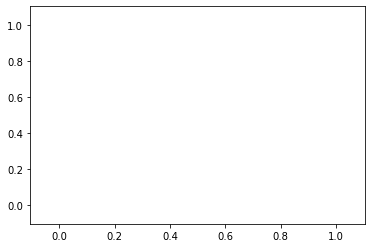

In [21]:
# Import Jia's analysis results
reservoir = pd.read_csv('./data/rdata/202010/Analysis20201124/Reservoir.csv')
prod = reservoir[['GRAND_ID', 'I_PF', 'I_DF', 'MdAPE']].set_index('GRAND_ID').rename({'I_PF':'PF', 'I_DF':'DF'}, axis=1)*100
prod['MdAPE'] = prod['MdAPE']/100

# High potential means I_PF > 4.7%
# Good forecast skill means x_MdAPE < 20%
high = prod['PF'] > 4.7; low = ~high
good = prod['MdAPE'] < 20; bad = ~good
print('High potential with good skill: %.1f%%' % ((high & good).sum()/ndam*100))
print('High potential with bad skill: %.1f%%' % ((high & bad).sum()/ndam*100))
patches = [plt.plot([],[], marker=m, ms=10, ls="", mec=c, color=(0,0,0,0), label=t)[0]\
           for m, c, t in zip(['^', 'v'], ['b','r'], ['Good forecast', 'Poor forecast'])];

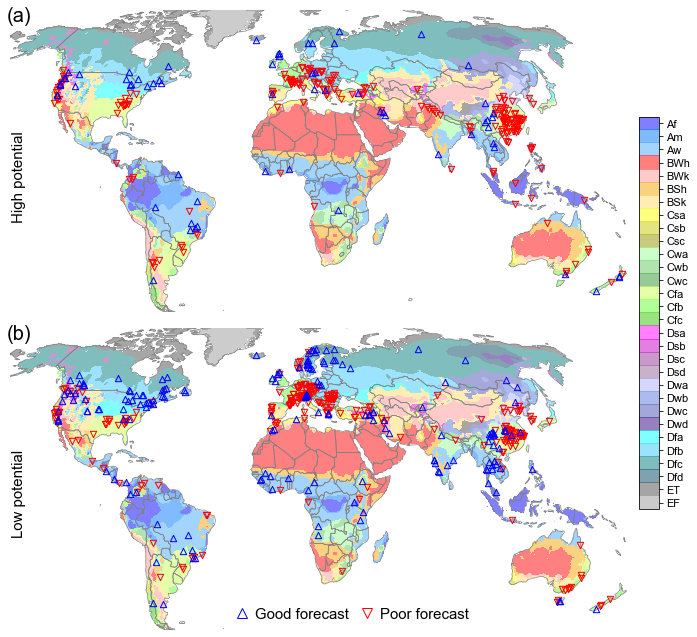

./figures/dam_class_2maps.pdf is saved.


In [25]:
# Merge Geodataframe of dam and Series of data we want to plot
# damMap = gdfDam.merge(subset, on='GRAND_ID')
damMap = gdfDam.set_index('GRAND_ID')

# Colormap
alpha = 0.5
kgc_cmap = colors.ListedColormap([list([*np.array(tup)/255, alpha]) for _, tup in cmap.items()])
kgc_bounds=np.array([0.5, *np.array(list(cmap.keys())) + 0.5])
kgc_norm = colors.BoundaryNorm(kgc_bounds, kgc_cmap.N)
kgc_cmap_bar = colors.ListedColormap([list([*np.array(tup)/255, alpha]) for _, tup in cmap.items()][:-2])
kgc_bounds_bar =np.array([0.5, *[*np.array(list(cmap.keys())) + 0.5]][:-2])
kgc_norm_bar = colors.BoundaryNorm(kgc_bounds_bar, kgc_cmap_bar.N)


# Plotting
fignumb = ['(a)', '(b)']
figlabel = ['High potential', 'Low potential']
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(9,9), facecolor='w')
for (i, el) in enumerate([high, low]):
    ax = axes[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    rasterio.plot.show(kgc, ax=ax, cmap=kgc_cmap, norm=kgc_norm)
    world.plot(ax=ax, color='None', edgecolor='gray', linewidth=0.7)
    damMap[el & bad].plot(ax=ax, marker = "v", markersize=40, edgecolor='red', facecolor=(0,0,0,0))
    damMap[el & good].plot(ax=ax, marker = '^', markersize=40, edgecolor='blue', facecolor=(0,0,0,0))
    ax.annotate(figlabel[i], xy=(0.015, 0.45), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=15, backgroundcolor="w", rotation=90)
    ax.annotate(fignumb[i], xy=(0.015, 0.98), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20, backgroundcolor="w")
    if i == 1:
        ax.legend(handles=patches, bbox_to_anchor=(0.55, 0.05), loc='center', ncol=2, 
                  handletextpad=0.1, handlelength=1.5, columnspacing= 0.5,
                  facecolor="w", prop={'family':'arial', 'size':15}, edgecolor='w')
plt.tight_layout()

# Colorbar
ax = axes[i]
cax = inset_axes(ax,
                 width="4%",
                 height="100%",
                 loc='right',
                 bbox_to_anchor=(0.25, 1.7, 0.8, -1.3),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=kgc_cmap_bar, norm=kgc_norm_bar,
                                 boundaries=kgc_bounds_bar,
                                 ticks = np.arange(1,33),
                                 spacing='uniform',
                                 orientation='vertical')
cbar.ax.set_yticklabels(rgb_code['Code'].values, fontname='arial', fontsize=11)
cbar.ax.tick_params(length=4)
cbar.outline.set_edgecolor('black')

plt.show()
# Save a figure
if True:
    fn_save = './figures/dam_class_2maps.pdf'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)